In [1]:
import wandb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from typing import Literal


project_name = "rulebots-eval-llm"

# get the api
api = wandb.Api()

# run names
run_names = {
    "base": "rwz1kdk6",
    "rules_llm": "kc395g5v",
    "rules_rl": "kytugwuj",
    "ppo_num": "ncacfcej",
}


def extract_from_history(s, history):
    x = history[s].values
    x = x[~np.isnan(x)]
    # if the series is longer than 25, take the last 20%
    n = len(x)
    if n > 25:
        x = x[int(0.8 * n) :]

    return x

### Plot 1 performance with environment reward

In [34]:
# Get the base agent data
base_agent_run = api.run(f"rulebots-eval-llm/{run_names['base']}")
base_agent_data = base_agent_run.history()

training_returns = {}
eval_returns = {}
rules_scores = {}

# base agent
training_returns["base"] = extract_from_history("charts/env_return", base_agent_data)
# eval_returns["base"] = extract_from_history("charts/episodic_return", base_agent_data)
eval_returns["base"] = training_returns["base"]  # same as training
print(base_agent_data.columns)

# Get the rules_llm agent data
rules_llm_run = api.run(f"rulebots-eval-llm/{run_names['rules_llm']}")
rules_llm_data = rules_llm_run.history()
print(rules_llm_data.columns)
training_returns["rules_llm"] = extract_from_history(
    "charts/env_return", rules_llm_data
)
eval_returns["rules_llm"] = training_returns["rules_llm"]  # same as training
# eval_returns["rules_llm"] = extract_from_history(
#     "charts/episodic_return", rules_llm_data
# )
rules_scores["rules_llm"] = [
    extract_from_history(f"charts/sel_reward_scores/q{i}", rules_llm_data)
    for i in range(5)
]


# Get the rules_rl agent data
rules_rl_run = api.run(f"rulebots/{run_names['rules_rl']}")
rules_rl_data = rules_rl_run.history()
print(rules_rl_data.columns)
training_returns["rules_rl"] = extract_from_history(
    "charts/env_return", rules_rl_data
)
eval_returns["rules_rl"] = extract_from_history(
    "charts/eval_episodic_return", rules_rl_data
)
rules_scores["rules_rl"] = [
    extract_from_history(f"charts/sel_reward_scores/q{i}", rules_rl_data)
    for i in range(5)
]

# Get numeric ppo agent data
ppo_num_run = api.run(f"rulebots-numeric/{run_names['ppo_num']}")
ppo_num_data = ppo_num_run.history()

training_returns["ppo_num"] = extract_from_history(
    "charts/episodic_return", ppo_num_data
)
eval_returns["ppo_num"] = extract_from_history(
    "charts/eval_episodic_return", ppo_num_data
)

Index(['charts/episodic_length', 'charts/episodic_return', '_step', '_runtime',
       '_timestamp', 'global_step', 'charts/env_return'],
      dtype='object')
Index(['_step', 'charts/episodic_return', '_runtime', 'global_step',
       '_timestamp', 'charts/episodic_length', 'charts/env_return',
       'charts/sel_rule_return', 'charts/total_return',
       'charts/sel_reward_scores/q0', 'charts/sel_reward_scores/q1',
       'charts/sel_reward_scores/q2', 'charts/sel_reward_scores/q3',
       'charts/sel_reward_scores/q4'],
      dtype='object')
Index(['charts/sel_reward_scores/q2', 'charts/sel_reward_scores/q3',
       'global_step', 'losses/old_approx_kl', '_step', 'losses/policy_loss',
       '_runtime', 'losses/value_loss', 'charts/eval_episodic_return',
       'charts/episodic_return', 'charts/sel_reward_scores/q1',
       'charts/episodic_length', 'charts/sel_rule_return',
       'charts/learning_rate', 'losses/explained_variance',
       'charts/total_reward', '_timestamp', 'cha

In [4]:
names_dict = {
    "base": "Base chain of thought (no rules)",
    "rules_llm": "Rule-based LLM (no RL)",
    "rules_rl": "Rule-based RL (PPO)",
    "ppo_num": "Numeric states (PPO)",
}

/var/folders/h3/2f91vbwj7r506n1w06610njh0000gn/T/ipykernel_3488/2379523747.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Agent', y='Returns', data=data, palette='muted')


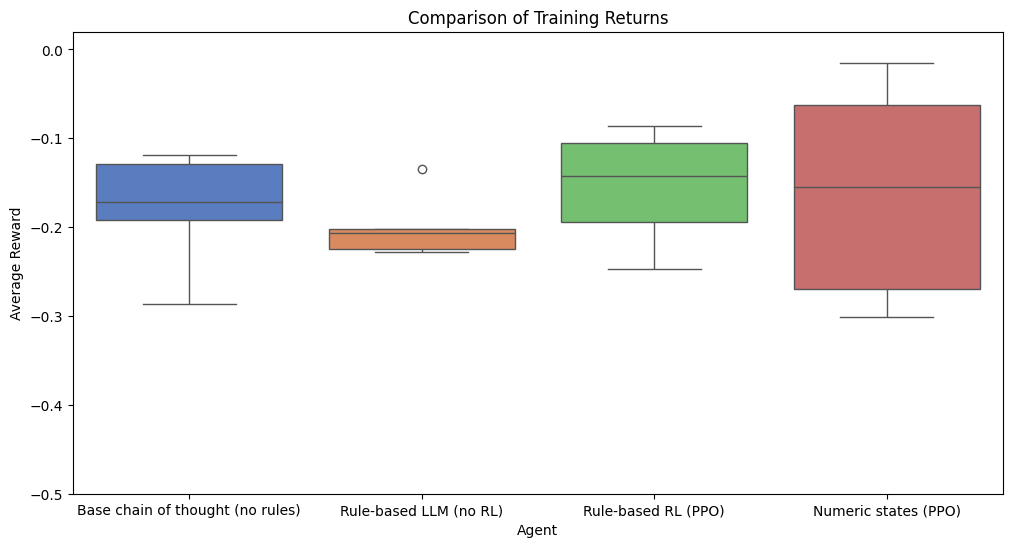

In [5]:
import seaborn as sns

# Create a new figure
plt.figure(figsize=(12, 6))

# Prepare data for violin plot
data = []
labels = []
for key, values in training_returns.items():
    # if key is numeric divide by 16
    if key == "ppo_num":
        values = values / 16
    data.extend(values)
    labels.extend([names_dict[key]] * len(values))

# Create a DataFrame for seaborn
data = pd.DataFrame({'Returns': data, 'Agent': labels})

# Plot boxplot
sns.boxplot(x='Agent', y='Returns', data=data, palette='muted')

# Add labels and title
plt.xlabel('Agent')
plt.ylabel('Returns')
plt.title('Comparison of Training Returns')

# Show the plot
plt.ylabel("Average Reward")
plt.ylim(-0.5, 0.02)
plt.show()


/var/folders/h3/2f91vbwj7r506n1w06610njh0000gn/T/ipykernel_3488/4291820151.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Agent', y='Returns', data=data, palette='muted')


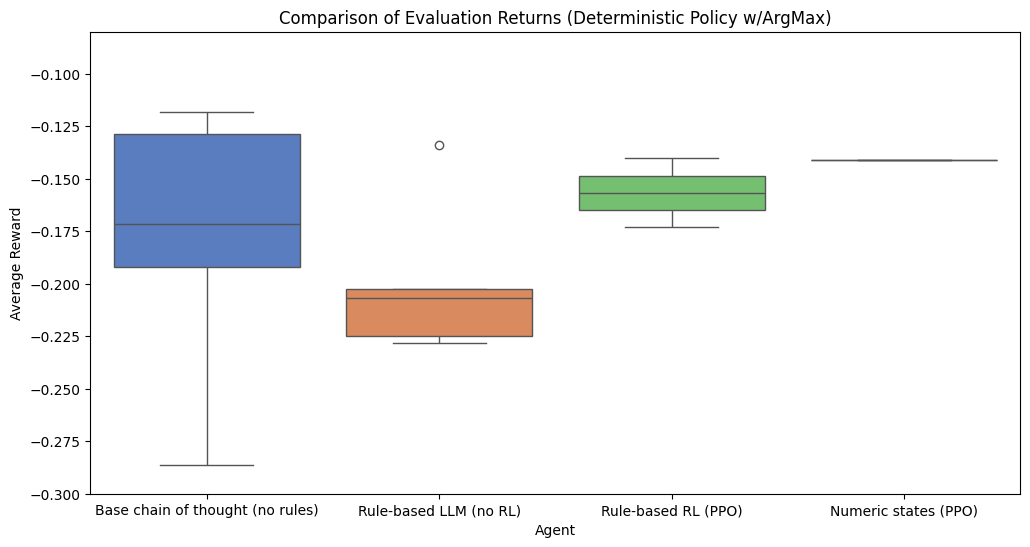

In [6]:
# Create a new figure
plt.figure(figsize=(12, 6))

# Prepare data for violin plot
data = []
labels = []
for key, values in eval_returns.items():
    # if key is numeric divide by 16
    data.extend(values)
    labels.extend([names_dict[key]] * len(values))

# Create a DataFrame for seaborn
data = pd.DataFrame({'Returns': data, 'Agent': labels})

# Plot boxplot
sns.boxplot(x='Agent', y='Returns', data=data, palette='muted')

# Add labels and title
plt.xlabel('Agent')
plt.ylabel('Returns')
plt.title('Comparison of Evaluation Returns (Deterministic Policy w/ArgMax)')

# Show the plot
plt.ylabel("Average Reward")
plt.ylim(-0.3, -0.08)
plt.show()

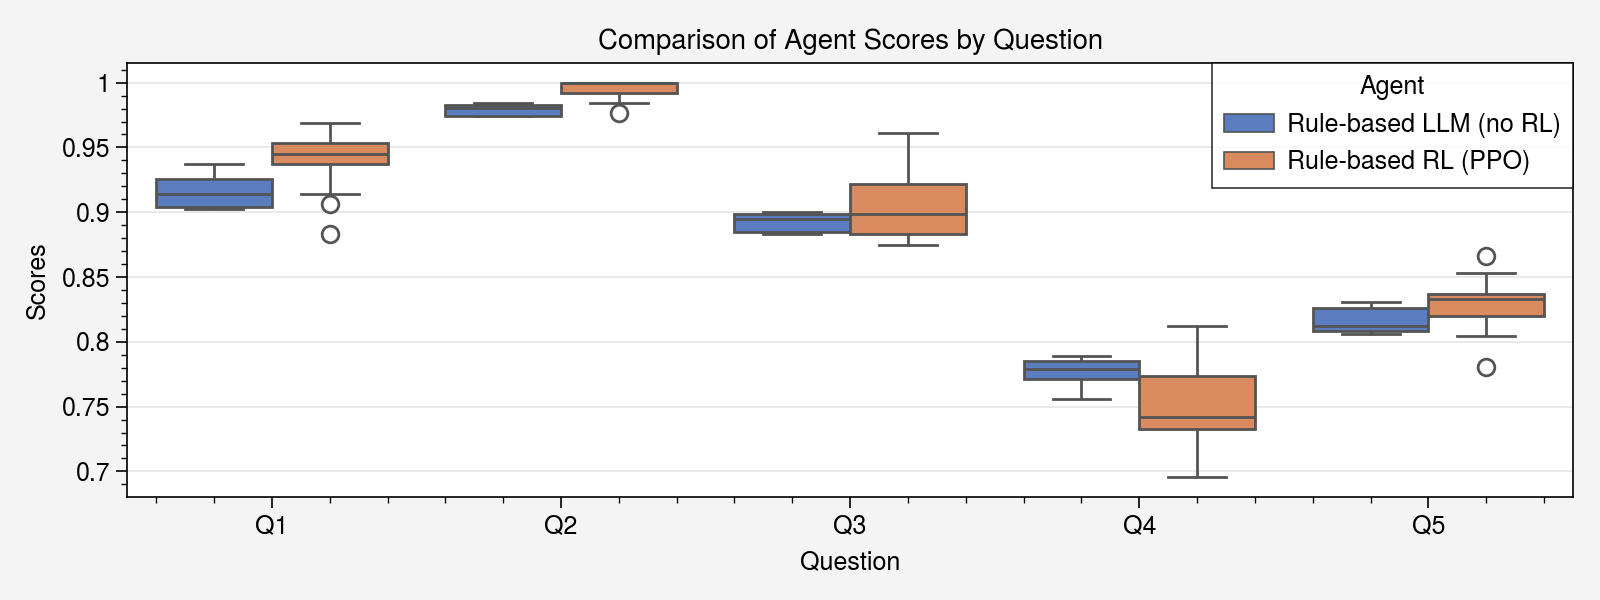

In [33]:
import seaborn as sns

q1 = "1. Are the rules sufficient to understand what action should you (the agent) do next?"
q2 = "2. Are the rules applicable to the current state of the decision problem?"
q3 = "3. Are the rules appropriately justified, without fallacies or hallucination?"
q4 = "4. The agent chose action {outputs['action']} based on the problem state. Are the selected rules sufficient to explain the decision?"
q5 = "5. Below is the explanation by the agent for the selected action. Rate it in a scale from 1 to 10."

# Prepare data for boxplot
scores = []
questions = []
agents = []

for i, question in enumerate([q1, q2, q3, q4, q5]):
    for agent, agent_scores in rules_scores.items():
        scores.extend(agent_scores[i])
        questions.extend([f"Q{i+1}"] * len(agent_scores[i]))
        agents.extend([names_dict[agent]] * len(agent_scores[i]))

# Create a DataFrame for seaborn
data = pd.DataFrame({'Scores': scores, 'Question': questions, 'Agent': agents})

# Create a new figure
plt.figure(figsize=(8, 3))

# Plot boxplots for each question
sns.boxplot(x='Question', y='Scores', hue='Agent', data=data, palette='muted')

# Set labels and title
plt.xlabel('Question')
plt.ylabel('Scores')
plt.title('Comparison of Agent Scores by Question')

# Add a single legend inside the plot
plt.legend(title='Agent', loc='upper right', bbox_to_anchor=(1, 1))

# Show the plot\
# tight_layout() adjusts the plot to the figure
plt.tight_layout()
plt.show()
